In [ ]:
#Install cpu only version of torchvision, for accessing MNIST dataset
#GPU version may have compatibility issues with JAX
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu  

In [3]:
import jax.numpy as jnp
from jax.nn import log_softmax,one_hot
from jax import grad,vmap
import jax
#jax.config.update('jax_default_matmul_precision', 'bfloat16')
import torchvision

def get_dataset_torch():
    mnist = {
        'train': torchvision.datasets.MNIST('./data', train=True, download=True),
        'test': torchvision.datasets.MNIST('./data', train=False, download=True)
    }

    ds = {}

    for split in ['train', 'test']:
        ds[split] = {
            'image': mnist[split].data.numpy(),
            'label': mnist[split].targets.numpy()
        }

        # cast from np to jnp and rescale the pixel values from [0,255] to [0,1]
        ds[split]['image'] = jnp.float32(ds[split]['image']) / 255.0
        ds[split]['label'] = jnp.int32(ds[split]['label'])

        # torchvision returns shape (B, 28, 28).
        # hence, append the trailing channel dimension.
        ds[split]['image'] = jnp.expand_dims(ds[split]['image'], 3)

    return ds['train'], ds['test']

train, test = get_dataset_torch()
train['image']=train['image'].reshape([60000,28*28])
train['image']=jnp.concatenate((train['image'],jnp.float32(jnp.ones([60000,1]))),1)
train['label']=jnp.float32(one_hot(train['label'],10))
test['image']=test['image'].reshape([10000,28*28])
test['image']=jnp.concatenate((test['image'],jnp.float32(jnp.ones([10000,1]))),1)
test['label']=jnp.float32(one_hot(test['label'],10))

In [4]:
@jax.jit
def lpost(beta):
    return jnp.sum(jnp.square(beta))*10/2-(log_softmax(train['image']@beta.reshape(785,10))*train['label']).sum()
grad_lpost=jax.jit(grad(lpost))
vmap_grad_lpost=vmap(grad_lpost)

import scipy.optimize
optim_res=scipy.optimize.minimize(lpost,jnp.zeros(7850),method="L-BFGS-B",jac=grad_lpost)
beta_min=optim_res.x

def hvp(x, v):
    return jax.grad(lambda x: jnp.vdot(grad_lpost(x), v))(x)
def hvp_beta_min(v):
    return hvp(beta_min, v)
vhvp_beta_min=vmap(hvp_beta_min)

from jax.lax import dynamic_update_slice
import numpy as np
ID=jnp.identity(7850)
nbeta=7850
hess_min=jnp.zeros([7850,7850])
vmap_size=25

for it in range(7850//vmap_size):
    slice1=ID[(it*vmap_size):((it+1)*vmap_size),:]
    hess1=vhvp_beta_min(slice1)
    hess_min=dynamic_update_slice(hess_min,hess1,(it*vmap_size,0))

hess_min=(hess_min+jnp.transpose(hess_min))/2
ehess_min,evhess_min=jnp.linalg.eigh(hess_min)
sqrt_D = jnp.diag(jnp.sqrt(ehess_min))
invsqrt_D = jnp.diag(jnp.pow(ehess_min,-0.5))

inv_sqrt_hess_min =  jnp.asarray(evhess_min @ invsqrt_D @ evhess_min.T)
def prob(beta):
    return jnp.exp((log_softmax(test['image']@beta.reshape(785,10))*test['label']).sum(axis=1))

prob_ind=np.asarray((prob(beta_min)>0.1)*(prob(beta_min)<0.9))
dim_prob_ind=np.sum(prob_ind)
test_image_ind=jnp.asarray(test['image'][prob_ind,:])
test_label_ind=jnp.asarray(test['label'][prob_ind,:])

def test_function(beta):
    return jnp.concatenate([beta,(jnp.exp((log_softmax(test_image_ind@beta.reshape(785,10))*test_label_ind).sum(axis=1)))])

vmap_test_function=vmap(test_function)

In [ ]:
from methods.multilevel_ubu import multilevel_ubu,vmap_generate_multilevels,vmap_multilevel_ubu
from jax import random

test_dim=dim_prob_ind+nbeta
M=jnp.max(ehess_min)
m=jnp.min(ehess_min)
r=4.0
c=1.0/16
maxlevel=8
max_parallel_chain=32
niter=2000
burnin=400
rep=128
h=jnp.array(1.0)/jnp.sqrt(M)
gam=jnp.sqrt(m)

key=random.key(3456674)
chunk_size=16
par_runs=16
keys=random.split(key,chunk_size)

res=vmap_multilevel_ubu(niter,burnin,rep,h,gam, vmap_grad_lpost, vmap_test_function, r,c,nbeta,test_dim,beta_min,maxlevel,max_parallel_chain, keys, chunk_size)

#_=multilevel_ubu(niter,burnin,rep,h,gam, vmap_grad_lpost_precond, vmap_test_function_precond, r,c,nbeta,test_dim,beta_min,maxlevel,max_parallel_chain, 4,key)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
Lev: 0 / 1 xn/x2n error: VmapTracer<float32[]>
h: 0.003739145 h/2: 0.0018695724
Lev: 1 / 2 xn/x2n error: VmapTracer<float32[]>
h: 0.0018695724 h/2: 0.0009347862
maxmultilevels: 5
multilevels: 1
Lev: 2 / 3 ...
hm: 0.0009347862
Multi error: VmapTracer<float32[6]>


In [ ]:
import time
key=random.key(487756)
par_runs=16*4
keys=random.split(key,par_runs)
start_time=time.time()
res=vmap_multilevel_ubu(niter,burnin,rep,h,gam, vmap_grad_lpost, vmap_test_function, r,c,nbeta,test_dim,beta_min,maxlevel,max_parallel_chain, keys, chunk_size)
end_time=time.time()
total_time=end_time-start_time
print("Total time:", total_time)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2]
Lev: 0 / 1 xn/x2n error: VmapTracer<float32[]>
h: 0.003739145 h/2: 0.0018695724
Lev: 1 / 2 xn/x2n error: VmapTracer<float32[]>
h: 0.0018695724 h/2: 0.0009347862
maxmultilevels: 5
multilevels: 0
Lev: 2 / 3 ...
hm: 0.0009347862
Multi error: VmapTracer<float32[6]>
Lev: 0 / 1 xn/x2n error: VmapTracer<float32[]>
h: 0.003739145 h/2: 0.0018695724
Lev: 1 / 2 xn/x2n error: VmapTracer<float32[]>
h: 0.0018695724 h/2: 0.0009347862
maxmultilevels: 5
multilevels: 0
Lev: 2 / 3 ...
hm: 0.0009347862
Multi error: VmapTracer<float32[6]>
Lev: 0 / 1 xn/x2n error: VmapTracer<float32[]>
h: 0.003739145 h/2: 0.0018695724
Lev: 1 / 2 xn/x2n error: VmapTracer<float32[]>
h: 0.0018695724 h/2: 0.0009347862
maxmultilevels: 5
multilevels: 0
Lev: 2 / 3 ...
hm: 0.0009347862
Multi error: VmapTracer<float32[6]>
Lev: 0 / 1 xn/x2n error: VmapTracer<float32[]>
h: 0.003739145 h/2: 0.0018695724
Lev

In [8]:
from methods.process_res_multi import process_res_multi
ess,grad_per_ess=process_res_multi(res,jnp.arange(par_runs))
print("max grad per ess coordinates:",jnp.max(grad_per_ess[:nbeta]))
print("min ess coordinates:",jnp.min(ess[:nbeta]))
print("ess/sec for UBUBU coordinates:",jnp.min(ess[:nbeta])/(total_time/par_runs))

print("max grad per ess prediction:",jnp.max(grad_per_ess[nbeta:]))
print("min ess prediction:",jnp.min(ess[nbeta:]))
print("ess/sec for UBUBU prediction:",jnp.min(ess[nbeta:])/(total_time/par_runs))



mean repruns: [1.28000e+02 8.00000e+00 2.00000e+00 1.00000e+00 1.40625e-01 6.25000e-02
 0.00000e+00 0.00000e+00 0.00000e+00]
test_mean_var: 6.390577e-05
ngradtot: 474025.0
test_mean_lev_0_comp1: 0.0011086483
max_test_mean_lev_0_var: 6.95879e-05
test_squaremean_lev_0_comp1: 0.09984262
blockstart: [  0 128 136 138 139 140 141 142 143]
blockend: [128 136 138 139 140 141 142 143 144]
maxlevel: 8
lev: 1
max_lev_test_mean_diff: 0.00029386947
max_lev_test_mean_diff_var: 5.273613e-07 repruns[lev+1,0]: 8
lev: 2
max_lev_test_mean_diff: 3.559814e-05
max_lev_test_mean_diff_var: 1.1887536e-08 repruns[lev+1,0]: 2
lev: 3
max_mean_diff_lev: 7.8065634e-05
max_test_mean_var: 4.287213e-08
test_post_var: 0.0998982
median test mean var: 2.968661e-05
median test post var: 0.059147663
min test post var: 0.0010932684
min_ess: 1427.5208
median_ess: 1991.3708
maxgradperess: 332.06174
mediangradperess: 238.03954
test_mean: 0.0009844777
test_squaremean: 0.099899165
max grad per ess coordinates: 332.06174
min ess 

In [ ]:
from methods.bootstrap_res import bootstrap_res
bootstrap_samp=256
key=random.key(23847)
keys=random.split(key,bootstrap_samp)
grad_per_ess_arr,max_grad_per_ess,max_grad_per_ess2,sd,sdmax,sdmax2=bootstrap_res(res,bootstrap_samp,par_runs,nbeta,process_res_multi,keys)

import pickle
with open('./output/MNIST_UBUBU.pkl', 'wb') as file:
    pickle.dump((ess, grad_per_ess,grad_per_ess_arr,max_grad_per_ess,max_grad_per_ess2,sd,sdmax,sdmax2),file)

In [2]:
import pickle
with open('./output/MNIST_UBUBU.pkl', 'rb') as file:
    (ess, grad_per_ess,grad_per_ess_arr,max_grad_per_ess,max_grad_per_ess2,sd,sdmax,sdmax2)=pickle.load(file)
print("Bootstrap sd for max grad per ess coordinates:", sdmax)
print("Bootstrap sd for max grad per ess prediction:", sdmax2)

Bootstrap sd for max grad per ess coordinates: 2.694769
Bootstrap sd for max grad per ess prediction: 2.821615


<Figure size 640x480 with 0 Axes>

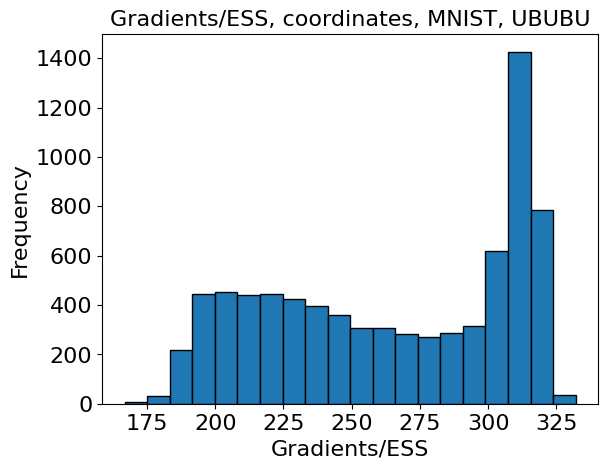

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
fig, ax = plt.subplots()
ax.set_xlabel("Gradients/ESS", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)
ax.set_title("Gradients/ESS, coordinates, MNIST, UBUBU",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.hist(grad_per_ess[0:nbeta],bins=20,histtype='bar',edgecolor='black')
plt.savefig("./output/UBUBU_MNIST_coordinates.pdf", format="pdf",bbox_inches='tight')  
plt.show()

<Figure size 640x480 with 0 Axes>

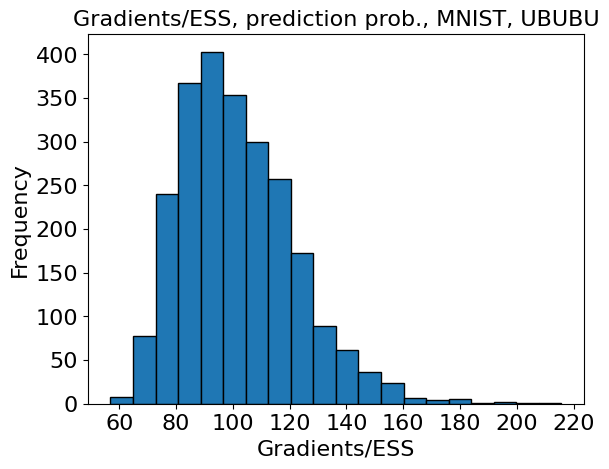

In [9]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
fig, ax = plt.subplots()
ax.set_xlabel("Gradients/ESS", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)
ax.set_title("Gradients/ESS, prediction prob., MNIST, UBUBU",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.hist(grad_per_ess[nbeta:],bins=20,histtype='bar',edgecolor='black')
plt.savefig("./output/UBUBU_MNIST_prediction_prob.pdf", format="pdf",bbox_inches='tight')  
plt.show()

In [ ]:
from methods.hmc import hmcsampler,vmap_hmcsampler
from methods.process_res_hmc import process_res_hmc
from jax import random
import time

niter=400
burnin=40
partial=0.7
numsteps=50
test_dim=nbeta+dim_prob_ind
nbeta=7850
par_runs=128
chunk_size=32
M=jnp.max(ehess_min)
m=jnp.min(ehess_min)
h=jnp.array(1.4)/jnp.sqrt(M)
key=random.key(12389)
keys=random.split(key,par_runs)
x0=jnp.ones([par_runs,1])@beta_min.reshape([1,nbeta])+random.normal(key,[par_runs,nbeta])@inv_sqrt_hess_min


In [ ]:
_=vmap_hmcsampler(niter,burnin,numsteps,partial,h,lpost,grad_lpost,test_function,test_dim,x0[0:chunk_size,],keys[0:chunk_size],chunk_size)

In [24]:
start_time=time.time()
res=vmap_hmcsampler(niter,burnin,numsteps,partial,h,lpost,grad_lpost,test_function,test_dim,x0,keys,chunk_size)
end_time=time.time()
total_time=end_time-start_time
print("Total time:", total_time)

Total time: 433.1752378940582


In [25]:
print("mean acceptance rate:", res[2].mean())
ess,grad_per_ess=process_res_hmc(res,jnp.arange(rep))

print("max grad per ess coordinates:",jnp.max(grad_per_ess[:nbeta]))
print("min ess coordinates:",jnp.min(ess[:nbeta]))
print("ess/sec for RHMC coordinates:",jnp.min(ess[:nbeta])/(total_time/par_runs))

print("max grad per ess prediction:",jnp.max(grad_per_ess[nbeta:]))
print("min ess prediction:",jnp.min(ess[nbeta:]))
print("ess/sec for RHMC prediction:",jnp.min(ess[nbeta:])/(total_time/par_runs))

mean acceptance rate: 0.69172585
max grad per ess coordinates: 365.94968
min ess coordinates: 60.117554
ess/sec for RHMC coordinates: 17.76428
max grad per ess prediction: 245.80045
min ess prediction: 89.5035
ess/sec for RHMC prediction: 26.447605


In [ ]:
from methods.bootstrap_res import bootstrap_res
bootstrap_samp=256
key=random.key(23847)
keys=random.split(key,bootstrap_samp)
grad_per_ess_arr,max_grad_per_ess,max_grad_per_ess2,sd,sdmax,sdmax2=bootstrap_res(res,bootstrap_samp,par_runs,nbeta,process_res_hmc,keys)


In [27]:
import pickle
with open("./output/MNIST_RHMC.pkl", "wb") as file:
    pickle.dump((ess, grad_per_ess,grad_per_ess_arr,max_grad_per_ess,max_grad_per_ess2,sd,sdmax,sdmax2),file)

In [10]:
import pickle
with open("./output/MNIST_RHMC.pkl", "rb") as file:
    (ess, grad_per_ess,grad_per_ess_arr,max_grad_per_ess,max_grad_per_ess2,sd,sdmax,sdmax2)=pickle.load(file)
print("Bootstrap sd for max grad per ess coordinates:", sdmax)
print("Bootstrap sd for max grad per ess prediction:", sdmax2)

Bootstrap sd for max grad per ess coordinates: 26.638464
Bootstrap sd for max grad per ess prediction: 19.648815


<Figure size 640x480 with 0 Axes>

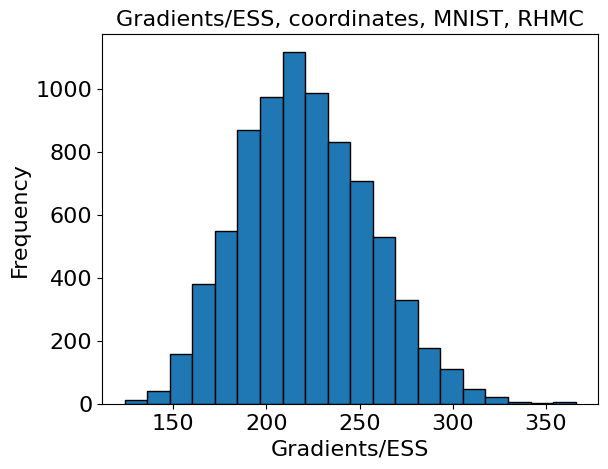

In [11]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
fig, ax = plt.subplots()
ax.set_xlabel("Gradients/ESS", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)
ax.set_title("Gradients/ESS, coordinates, MNIST, RHMC",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.hist(grad_per_ess[:nbeta],bins=20,histtype='bar',edgecolor='black')
plt.savefig("./output/RHMC_MNIST_coordinates.pdf", format="pdf",bbox_inches='tight')  
plt.show()


<Figure size 640x480 with 0 Axes>

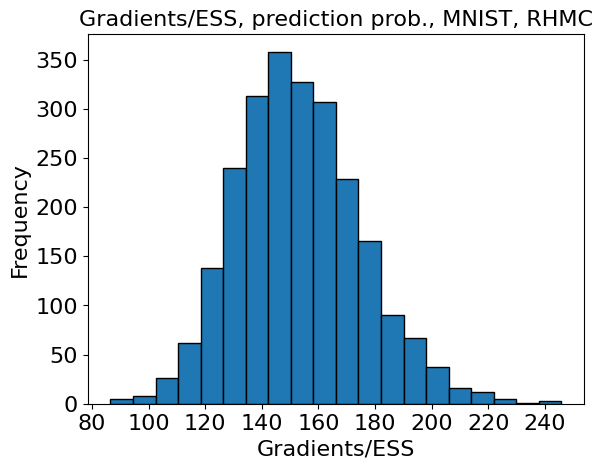

In [13]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
fig, ax = plt.subplots()
ax.set_xlabel("Gradients/ESS", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)
ax.set_title("Gradients/ESS, prediction prob., MNIST, RHMC",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.hist(grad_per_ess[nbeta:],bins=20,histtype='bar',edgecolor='black')
plt.savefig("./output/RHMC_MNIST_prediction_prob.pdf", format="pdf",bbox_inches='tight')  
plt.show()